# Time Series Modelling for Climate Change Forecast

There are several types of time series forecast models. In this notebook I will try to use [Seasonal ARIMA Models](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average). I took Leandro Rabelo's [notebook](https://www.kaggle.com/leandrovrabelo/climate-change-forecast-sarima-model/notebook) on the climate change in Rio de Janeiro and generalize it to global average temperatures . I used the dataset of Berkeley Earth from [kaggle](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data) with monthly average global surface temperatures from 1850 to 2015. I initially used monthly average land surface temperatures and found that the best fitted iterable for the trend is [0,1,0,0,1]. I tried to tune the iterable for the worst case scenario, you can try different iterables for more optimistic results.

In [1]:
import time
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# reading and transforming the file
df = pd.read_csv("global-temperatures.csv", parse_dates = True, index_col=0)
df.head()

,Temp
Date,
1850-01-01,12.833
1850-02-01,13.588
1850-03-01,14.043
1850-04-01,14.667
1850-05-01,15.507


In [3]:
# setting pre-industrial average as the average temperature between 1850 - 1900
print('Pre-industrial avreage land surface temperature is  8.1.')
base_average = sum(df.Temp[:600])/600
print('Pre-industrial average global surface temperature is ', str(round(base_average, 1)) + '.')

Pre-industrial avreage land surface temperature is  8.1.
Pre-industrial average global surface temperature is  15.0.


Below I'll try to make a brief explanation about ARIMA models:

# <font color=green>SARIMA Model (p, d, q)(P, D, Q, S)</font>:
SARIMA stands for Seasonal Auto Regressive Integrated Moving Average, The name scares, but this is not as scary as it seems.

## <font color=green>Non seasonal ARIMA</font>:

We can split the Arima term into three terms, AR, I, MA:

 * **AR(p)** stands for *autoregressive model*, the `p` parameter is an integer that confirms how many lagged series are going to be used to forecast periods ahead, example:
     * The average temperature of yesterday has a high correlation with the temperature of today, so we will use AR(1) parameter to forecast future temperatures.
     * The formula for the AR(p) model is: $\hat{y}_{t} = \mu + \theta_{1}Y_{t-1} + ... + \theta_{p}Y_{t-p}$. Where $\mu$ is the constant term, **p** is the periods to be used in the regression and, $\theta$ is the parameter fitted to the data.
     
 * **I(d)** is the differencing part, the `d` parameter tells how many differencing orders are going to be used, it tries to make the series stationary, example:
 
     * Yesterday I sold 10 items of a product, today I sold 14, the "I" in this case is just the first difference, which is +4, if you are using logarithm base this difference is equivalent to percentual difference. 
     * If d = 1: $y_{t} = Y_{t} - Y_{t-1}$ where $y_{t}$ is the differenced series and $Y_{t-period}$ is the original series.
     * If d = 2: $y_{t} = (Y_{t} - Y_{t-1}) - (Y_{t-1} - Y_{t-2}) = Y_{t} - 2Y_{t-1} + Y_{t-2}$.
     * Note that the second difference is a change in change, which is a measure of the local "acceleration" rather than trend.

* **MA(q)** stands for *moving average model*, the `q` is the number of lagged forecast errors terms in the prediction equation, example:
     * It's strange, but this MA term takes a percentage of the errors between the predicted value against the real. It assumes that the past errors are going to be similar in future events.
     * The formula for the MA(q) model is: $\hat{y}_{t} = \mu + e_{t} + \Theta_{1}e_{t-1} + ... + \Theta_{q}e_{t-q}$. Where $\mu$ is the constant term, **q** is the period to be used on the $e$ term and, $\Theta$ is the parameter fitted to the errors.     
## <font color=green>Seasonal ARIMA</font>:

The **p, d, q** parameters are capitalized to differ from the non seasonal parameters.

* **SAR(P)** is the seasonal autoregression of the series.
    * The formula for the SAR(P) model is: $\hat{y}_{t} = \mu + \theta_{1}Y_{t-s}$ Where P is the quantity of autoregression terms to be added, usually no more than 1 term, **s** is the difference between base value time and current value time and, $\theta$ is the parameter fitted to the data.
    * Usually when the subject is weather forecasting, 12 months ago have some information to contribute to the current period.
    * Setting P=1 (i.e., SAR(1)) adds a multiple of $Y_{t-s}$ to the forecast for $y_{t}$.
    
* **I(D)** the seasonal difference MUST be used when you have a strong and stable pattern.
     * If d = 0 and D = 1: $y_{t} = Y_{t} - Y_{t-s}$ where $y_{t}$ is the differenced series and $Y_{t-s}$ is the original seasonal lag.
     * If d =1 and D = 1: $y_{t} = (Y_{t} - Y_{t-1}) - (Y_{t-s} - Y_{t-s-1})$.
     * D should never be more than 1, and d+D should never be more than 2. Also, if d+D = 2, the constant term should be suppressed.
     
* **SMA(Q)** 
     * Setting Q=1 (i.e., SMA(1)) adds a multiple of error $e_{t-s}$ to the forecast for $y_{t}$.


* **S** It's the seasonal period where you are going to calculate the the P, D, Q terms. If there is a 52 week seasonal correlation this is the number to be used on the 'S' parameter
  
  ## <font color=green>Trend</font>:
  
We will use [SARIMAX](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) to create a forecast, the following terms are a definition to the trend:

 * 'n' when there is no trend to be used (default)
 * ‘c’ indicating a constant (i.e. a degree zero component of the trend polynomial)
 * ‘t’ indicating a linear trend with time
 * ‘ct’ as both trend and constant. 
 * The trend can also be specified as an iterable defining the polynomial as in numpy.poly1d, where [1,1,0,1] would denote a+bt+ct^3.


Now, let's plot the series and check how it behaves.

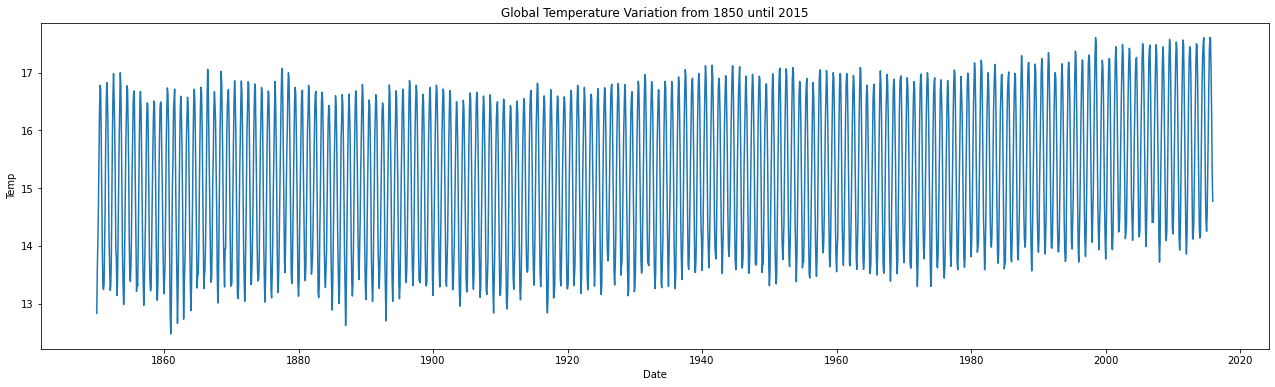

In [4]:
plt.figure(figsize=(22,6))
sns.lineplot(x=df.index, y=df['Temp'])
plt.title('Global Temperature Variation from 1850 until 2015')
plt.show()

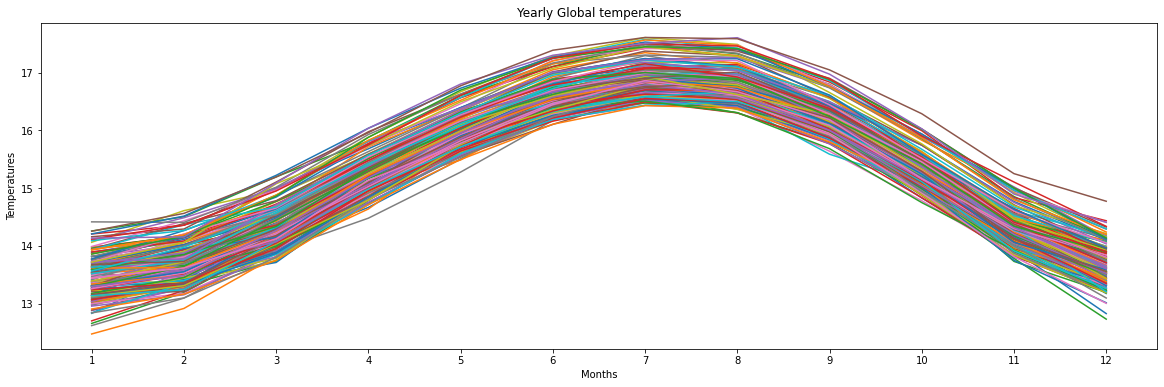

In [5]:
# I'm going to create a pivot table to plot the monthly temperatures through the years.
df['month'] = df.index.month
df['year'] = df.index.year
pivot = pd.pivot_table(df, values='Temp', index='month', columns='year', aggfunc='mean')
pivot.plot(figsize=(20,6))
plt.title('Yearly Global temperatures')
plt.xlabel('Months')
plt.ylabel('Temperatures')
plt.xticks([x for x in range(1,13)])
plt.legend().remove()
plt.show()

The series clearly has some seasonality, the higher temperatures are in July and the lower ones are in between December and January. Just to make the things clear, I'll merge these lines into just one line by averaging the monthly levels.

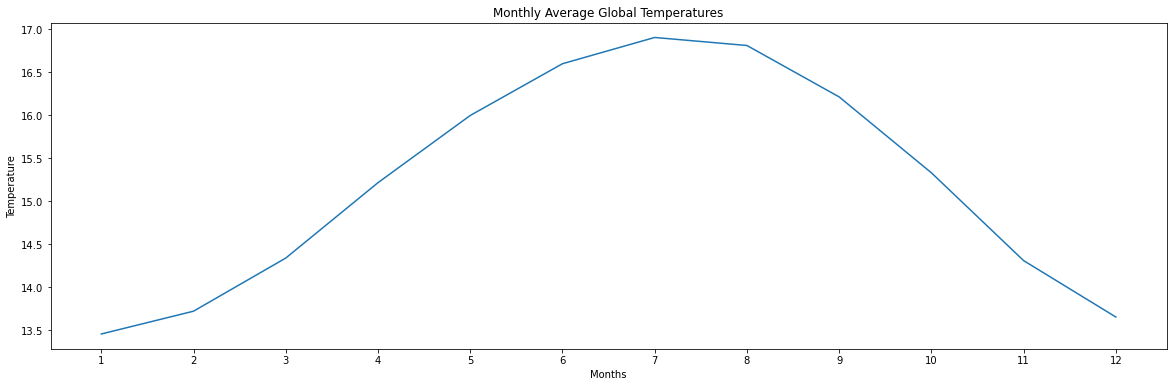

In [6]:
monthly_seasonality = pivot.mean(axis=1)
monthly_seasonality.plot(figsize=(20,6))
plt.title('Monthly Average Global Temperatures')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(1,13)])
plt.show()

Now I'm going to check if there is some trend through the years in this series.

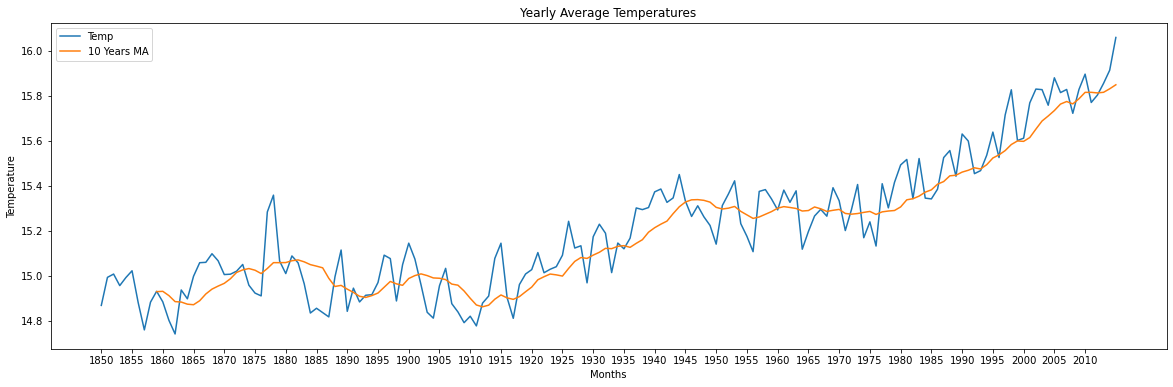

In [7]:
year_avg = pd.pivot_table(df, values='Temp', index='year', aggfunc='mean')
year_avg['10 Years MA'] = year_avg['Temp'].rolling(10).mean()
year_avg[['Temp','10 Years MA']].plot(figsize=(20,6))
plt.title('Yearly Average Temperatures')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(1850,2015,5)])
plt.show()

We can confirm that there is a constant increasing trend and that the average temperature increased from 15.0º to 16.1º in over 150 years. For land surface data temperature change is from 8.1º to 9.8º.

Before we go on, i'm going to split the data in training, validation and test set. After training the model, I will use the last 10 years to do the data validation and test, being 96 months to do a month by month validation (walk forward) and 24 months to make an extrapolation for the future and compare to the test set.

In [8]:
train = df[:-120].copy()  # around 94 %
val = df[-120:-24].copy() # around 5 %
test = df[-24:].copy()    # around 1 %

And before creating the forecasts we will create a baseline forecast in the validation set, in our simulation we will try to have a smaller error compared to this one.

It will consider the previous month as a base for the forecast of the next month.

In [9]:
# excluding the first line, as it has NaN values
baseline = val['Temp'].shift()
baseline.dropna(inplace=True)
baseline.head()

Date
2006-02-01    13.990
2006-03-01    14.435
2006-04-01    14.966
2006-05-01    15.729
2006-06-01    16.463
Name: Temp, dtype: float64

Also I'm going to create a function to use the [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) to calculate the error, but you are free to use another parameter.

In [10]:
def measure_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true,y_pred))

# using the function with the baseline values
rmse_base = measure_rmse(val.iloc[1:,0],baseline)
print(f'The RMSE of the baseline that we will try to diminish is {round(rmse_base, 4)} celsius.')

The RMSE of the baseline that we will try to diminish is 0.6534 celsius.


As we can see, the series has a small uptrend and it appears that there is some seasonality with low temperatures at the begining and end of the year and high temperatures around the middle of the year.

To create a time series forecast, the series must be stationary (constant mean, variance and autocorrelation).

One way to check if the series is stationary is using the **adfuller function**, if the "p-value" is lower than 5% (usual number used for this kind of study) the series is stationary and you can start creating your model. 

If the series isn't stationary you can do some data transformation like using natural logarithm, deflation, differencing, etc.

Below is the function that I used to check the stationarity, it plots: 

 * The series itself;
 * The autocorrelation function **(ACF)**:
      * It shows the correlation between the current temperatures versus the lagged versions of itself.
 * The partial autocorrelation **(PACF)**:
     * It shows the correlation between the current temperatures versus the lagged version excluding the effects of earlier lags, for example, it show the effective influence of the lag 3 in the current temperatures excluding the effects of the lags 1 and 2.

For more interesting sources you can read the materials on this amazing website made by Mr. Robert Nau: [ Duke University](http://people.duke.edu/~rnau/411home.htm), also you can check [Jason Brownlee's](machinelearningmastery.com) website, which have a lot of time series content.

In [11]:
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"
    
    # creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('Global Temperature Variation')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

Results of Dickey-Fuller Test:
Test Statistic                   -1.4907
p-value                           0.5381
Lags Used                        25.0000
Number of Observations Used    1846.0000
Critical Value (1%)              -3.4339
Critical Value (5%)              -2.8631
Critical Value (10%)             -2.5676
dtype: float64

The Test Statistics is higher than the Critical Value of 5%.
The serie isn't stationary


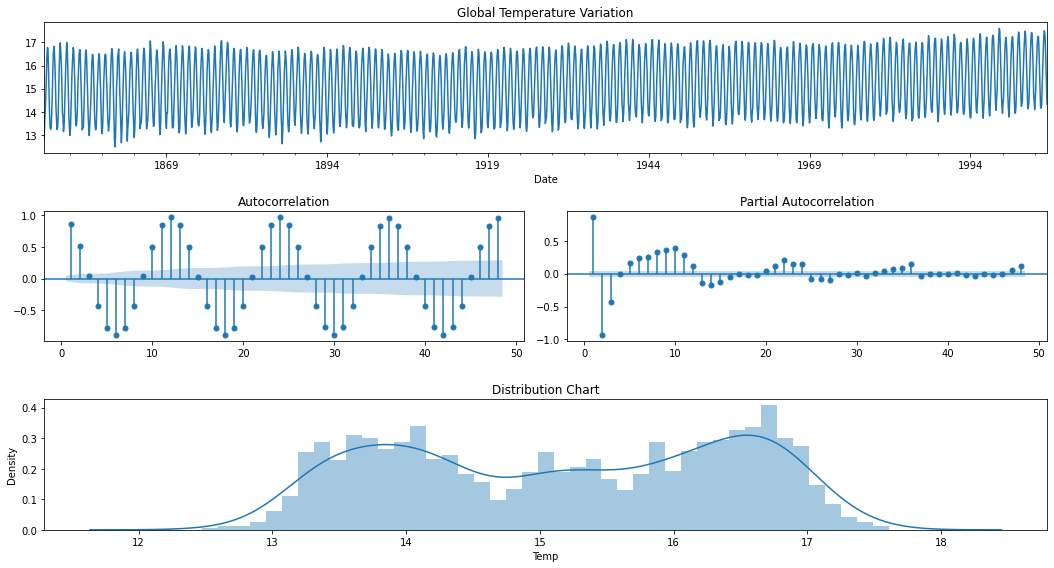

In [12]:
# the first approach is to check the series without any transformation
check_stationarity(train['Temp'])

The series has an interesting behavior, there is a sequential significative negative autocorrelation starting at lag 6 and repeating each 12 months, it's because of the difference in the seasons, if today is winter with cold temperatures in 6 months we will have higher temperatures in the summer, that's why the negative autocorrelation occurs. These temperatures usually walk in opposite directions.

Also, from lag 12 and sequentially from every 12 lags there is a significant positive autocorrelation. The **PACF** shows a positive spike in the first lag and a drop to negative **PACF** in the following lags.

This behavior between the **ACF** and **PACF** plots suggests an AR(1) model and also a first seasonal difference ($Y_{t} - Y_{t-12}$). I'll plot the stationarity function again with the first seasonal difference to see if we will need some SAR(P) or SMA(Q) parameter.

Results of Dickey-Fuller Test:
Test Statistic                  -11.6310
p-value                           0.0000
Lags Used                        24.0000
Number of Observations Used    1835.0000
Critical Value (1%)              -3.4339
Critical Value (5%)              -2.8631
Critical Value (10%)             -2.5676
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


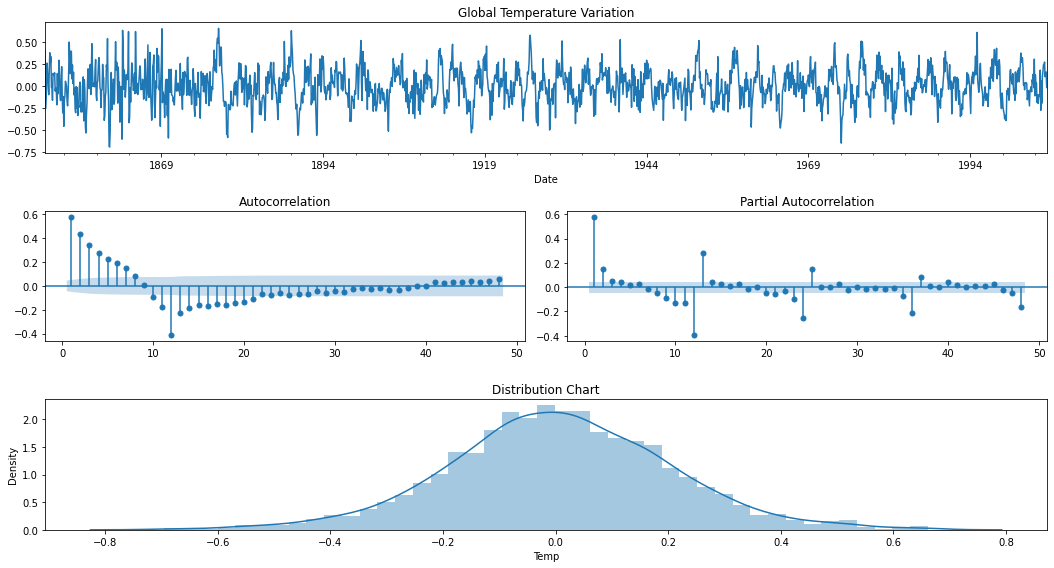

In [13]:
check_stationarity(train['Temp'].diff(12).dropna())

As the plots above showed, the first **ACF** lags have a gradual decay, while the **PACF** drops under the confidence interval after the third lag, this is an **AR** signature with a parameter of 3, so this is an **AR(3)** model.

As we used a first seasonal difference, the **ACF** and **PACF** showed a significative drop in the 12th lag, it means an **SMA** signature with a parameter of 1 lag, resuming this is an **SAR(1) with a first difference**.

Initially I'm going to work with the following (p,d,q) orders: (3, 0, 0), and with the following seasonal (P, D, Q, S) orders (0,1,1,12) and as the series has a clear uptrend I'm going to use "[0,1,0,0,1]". 
 
 To start forecasting the validation set, I'm going to implement a function to use one-step-forecast in the whole validation set and measure the error.

In [14]:
def walk_forward(training_set, validation_set, params):
    '''
    Params: it's a tuple where you put together the following SARIMA parameters: ((pdq), (PDQS), trend)
    '''
    history = [x for x in training_set.values]
    prediction = list()
    
    # using the SARIMA parameters and fitting the data
    pdq, PDQS, trend = params
    
    month = 0

    # forecasting one period ahead in the validation set
    for i in tqdm(range(len(validation_set))):
        model = sm.tsa.statespace.SARIMAX(history, order=pdq, seasonal_order=PDQS, trend=trend)
        result = model.fit(disp=False)
        yhat = result.predict(start=len(history), end=len(history))
        prediction.append(yhat[0])
        history.append(validation_set[month])
        month += 1
        
    return prediction

In [15]:
# let's test it in the validation set with the trend curve "at + bt^4"
val['Pred'] = walk_forward(train['Temp'], val['Temp'], ((3,0,0),(0,1,1,12), [0,1,0,0,1]))

100%|██████████| 96/96 [15:08<00:00,  9.46s/it]


In [16]:
# measuring the error of the prediction
rmse_pred = measure_rmse(val['Temp'], val['Pred'])

print(f"The RMSE of the SARIMA(3,0,0),(0,1,1,12),'[0,1,0,0,1]' model was {round(rmse_pred, 4)} celsius degrees")
print(f"It's a decrease of {round((rmse_pred/rmse_base-1)*100, 2)}% in the RMSE")

The RMSE of the SARIMA(3,0,0),(0,1,1,12),'[0,1,0,0,1]' model was 0.1049 celsius degrees
It's a decrease of -83.94% in the RMSE


In [17]:
# creating the error column
val['Error'] = val['Temp'] - val['Pred']

It's always important to check the residuals, I'm going to create a function to plot some important charts to help us visualize the residuals.

I'm going to plot the following charts:
* current and predicted values through the time
* residuals vs. predicted values in an scatterplot
* QQ plot showing the distribution of errors and its ideal distribution
* autocorrelation plot of the residuals to see if there is some correlation left.

In [18]:
def plot_error(data, figsize=(20,8)):
    '''
    There must have 3 columns following this order: Temperature, Prediction, Error
    '''
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    #Plotting the Current and Predicted values
    ax1.plot(data.iloc[:,0:2])
    ax1.legend(['Real','Pred'])
    ax1.set_title('Current and Predicted Values')
    
    # Residual vs Predicted values
    ax2.scatter(data.iloc[:,1], data.iloc[:,2])
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Errors')
    ax2.set_title('Errors versus Predicted Values')
    
    ## QQ Plot of the residual
    sm.graphics.qqplot(data.iloc[:,2], line='r', ax=ax3)
    
    # Autocorrelation plot of the residual
    plot_acf(data.iloc[:,2], lags=(len(data.iloc[:,2])-1),zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

In [19]:
# we need to remove some columns to plot the charts
val.drop(['month','year'], axis=1, inplace=True)
val.head()

,Temp,Pred,Error
Date,,,
2006-01-01,13.990,14.219057,-0.229057
2006-02-01,14.435,14.341525,0.093475
2006-03-01,14.966,15.078663,-0.112663
2006-04-01,15.729,15.846579,-0.117579
2006-05-01,16.463,16.484614,-0.021614


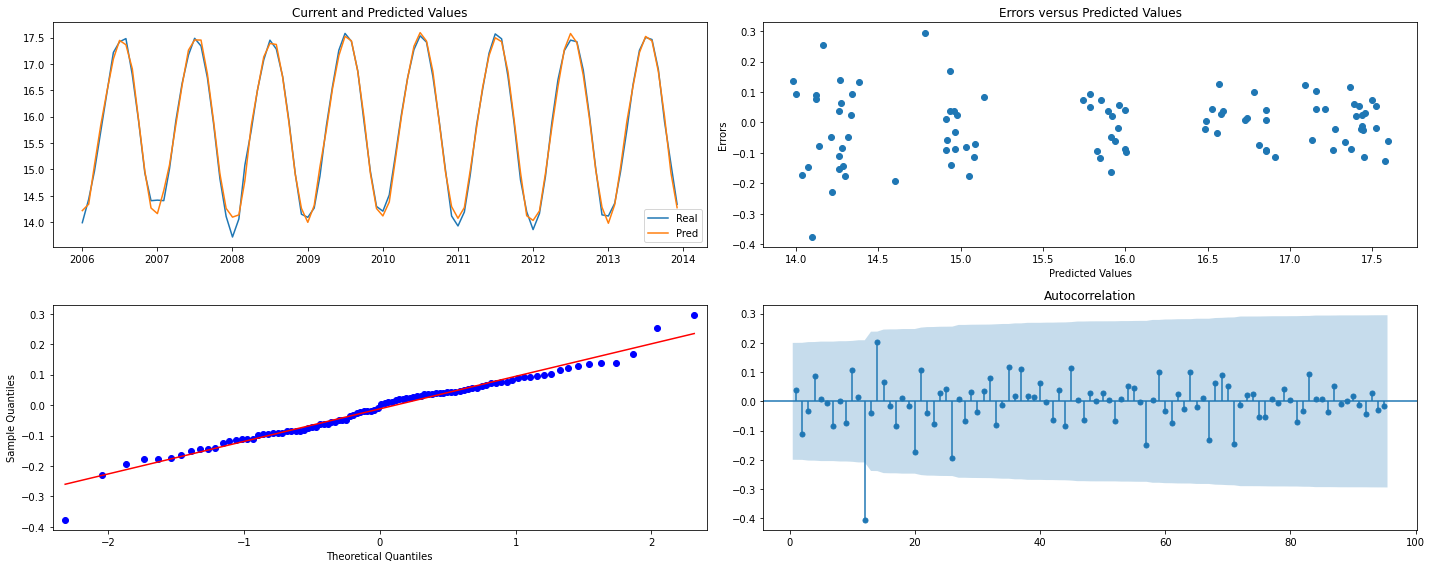

In [20]:
plot_error(val)

Analyzing the plots above we can see that the predictions fit very well on the current values.

The **Error vs Predicted values** has a linear distribution. Error values are between -0.3 and +0.3 while the temperature increases. Error values were between -1 and +1 for the average land surface temperatures.

The QQ Plot shows a normal pattern with some little outliers.

The autocorrelation plot shows a positive spike over the confidence interval just above the second lag, but I believe that there is no need for more changes.

Finally it's time to extrapolate the prediction in the **test set** for the last 24 months.

In [21]:
# creating the new concatenating the training and validation set:
future = pd.concat([train['Temp'], val['Temp']])
future.head()

Date
1850-01-01    12.833
1850-02-01    13.588
1850-03-01    14.043
1850-04-01    14.667
1850-05-01    15.507
Name: Temp, dtype: float64

In [22]:
# using the same parameters of the fitted model
start = time.time()
model = sm.tsa.statespace.SARIMAX(future, order=(3,0,0), seasonal_order=(0,1,1,12), trend=[0,1,0,0,1])
result = model.fit(disp=False)
print('elapsed time:', "{:.2f}".format(time.time() - start), 'seconds')

elapsed time: 9.83 seconds


Now I'm going to create a new column on the test set with the predicted values and I will compare them against the real values.

In [23]:
test['Pred'] = result.predict(start=(len(future)), end=(len(future)+25))

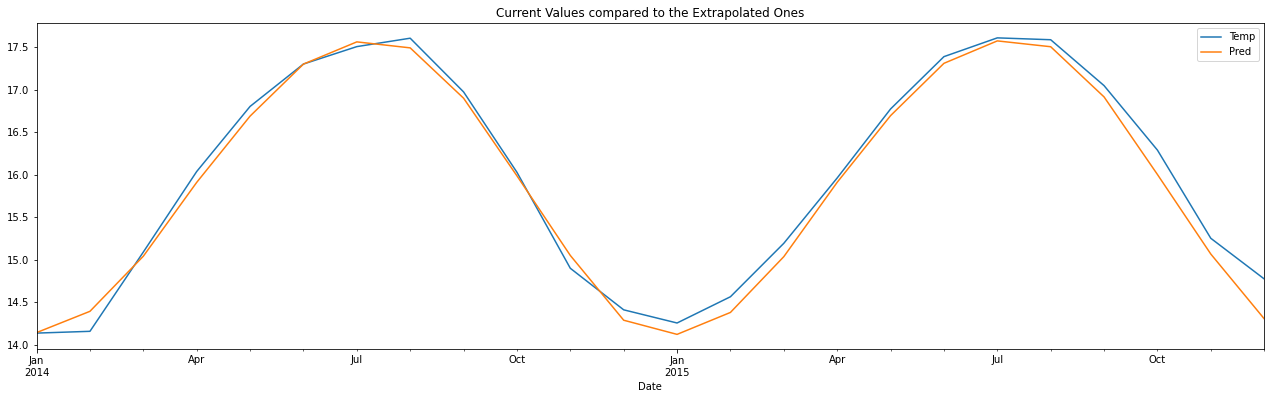

In [24]:
test[['Temp', 'Pred']].plot(figsize=(22,6))
plt.title('Current Values compared to the Extrapolated Ones')
plt.show()

It seems that the SARIMA parameters were well fitted, the predicted values follow the real values and also the seasonal pattern.

Finally I'll evaluate the model with the RMSE in the test set (baseline against the extrapolation).

In [25]:
test_baseline = test['Temp'].shift()

test_baseline[0] = test['Temp'][0]

rmse_test_base = measure_rmse(test['Temp'],test_baseline)
rmse_test_extrap = measure_rmse(test['Temp'], test['Pred'])

print(f'The baseline RMSE for the test baseline was {round(rmse_test_base, 4)} celsius.')
print(f'The baseline RMSE for the test extrapolation was {round(rmse_test_extrap, 4)} celsius.')
print(f'That is an improvement of {-round((rmse_test_extrap/rmse_test_base-1)*100,2)}%.')

The baseline RMSE for the test baseline was 0.6402 celsius.
The baseline RMSE for the test extrapolation was 0.1584 celsius.
That is an improvement of 75.26%.


7.3 celsius increase is expected for the average land surface temperature by the year 2100.
4.3 celsius increase is expected for the average global surface temperature by the year 2100.


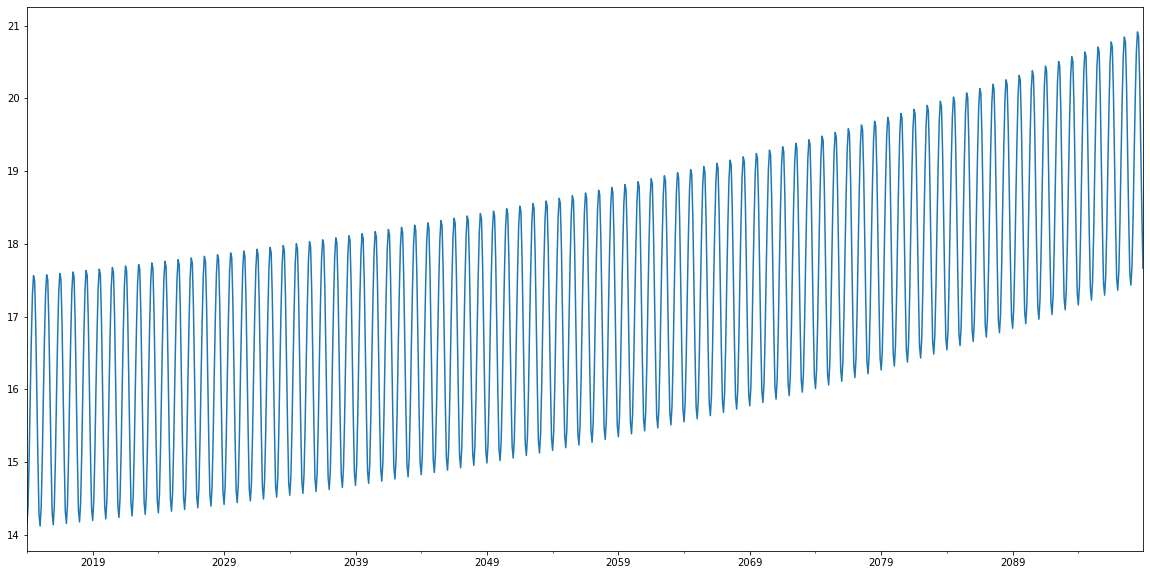

In [26]:
# check out the predicted values for the next years
print('7.3 celsius increase is expected for the average land surface temperature by the year 2100.')

monthly_forecast = result.forecast(steps=12*85)
print(round(sum(monthly_forecast[-12:])/12 - base_average, 1) ,'celsius increase is expected for the average global surface temperature by the year 2100.')
monthly_forecast.plot(figsize=(20,10))
plt.show()

I hope you like this analysis. If you have any doubt or comment, feel free to write to me via [github](https://github.com/hguyanik) or [twitter](https://twitter.com/thelykian).